In [1]:
import yfinance as yf
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LambdaCallback

In [2]:
# Set seed for result reproductibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
# Download stock data for corporates
stock_data_comm = yf.download('CBA.AX', start='2010-01-01')
stock_data_westpac = yf.download('WBC.AX', start='2010-01-01')
stock_data_nab = yf.download('NAB.AX', start='2010-01-01')
stock_data_anz = yf.download('ANZ.AX', start='2010-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


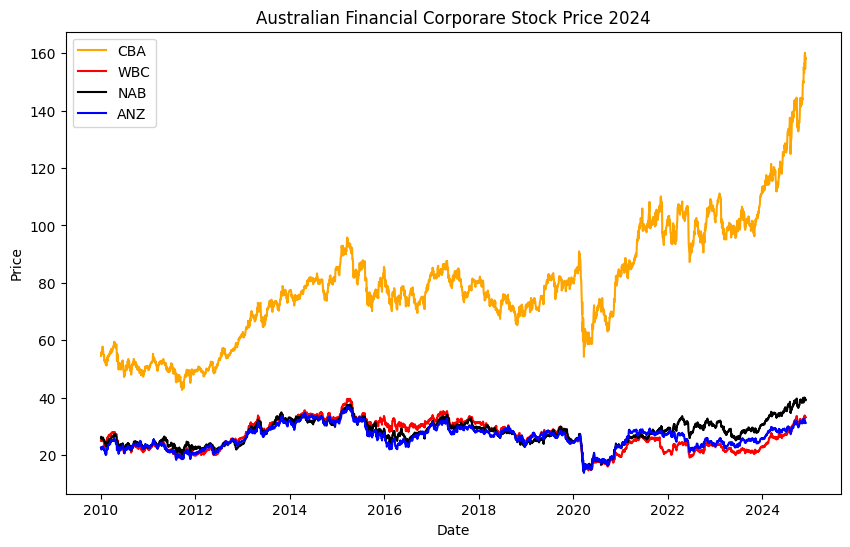

In [4]:
# Plot the stock prices
plt.figure(figsize=(10,6))
plt.plot(stock_data_comm['Close'], label = 'CBA', color = 'orange')
plt.plot(stock_data_westpac['Close'], label = 'WBC', color = 'red')
plt.plot(stock_data_nab['Close'], label = 'NAB', color = 'black')
plt.plot(stock_data_anz['Close'], label = 'ANZ', color = 'blue')
plt.title('Australian Financial Corporare Stock Price 2024')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [5]:
# Create time windows for training the model
def create_time_windows_multi_step(data, window_size, forecast_steps):
    X = []
    Y = []
    for i in range(window_size, len(data) - forecast_steps):
        X.append(data[i-window_size:i, 0])
        Y.append(data[i+forecast_steps, 0])
    return np.array(X), np.array(Y)

# Modify preprocessing to include forecast_steps
def preprocess_data_multi_step(stock_data, window_size=60, forecast_steps=1):
    stock_prices = stock_data['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_prices_scaled = scaler.fit_transform(stock_prices)

    X, Y = create_time_windows_multi_step(stock_prices_scaled, window_size, forecast_steps)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]
    
    return X_train, Y_train, X_test, Y_test, scaler, stock_prices_scaled

In [6]:
def build_model(X_train, Y_train, X_test, Y_test):
    # Build the LSTM model
    model = models.Sequential([
        layers.Input(shape = (X_train.shape[1], 1)),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Output layer (predicted price)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Define the custom callback to show only for the first and last epoch (epoch 1/20 and epoch 20/20)
    custom_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(
            f"Epoch {epoch + 1}/{20} - loss: {logs['loss']:.4f}, val_loss: {logs['val_loss']:.4f}"
        ) if epoch in [0, 19] else None 
    )

    # Train the model
    model.fit(
        X_train, Y_train, 
        epochs=20, 
        batch_size=32, 
        validation_data=(X_test, Y_test), 
        callbacks=[custom_callback],
        verbose=0
        )
    
    return model

In [7]:
def compare_predictions(model, X_test, Y_test, scaler):
    # Make predictions on the test set
    predicted_prices = model.predict(X_test)

    # Inverse transform the predicted and actual prices to get original scale
    predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
    actual_prices = scaler.inverse_transform(Y_test.reshape(-1, 1))

    return predicted_prices, actual_prices

In [8]:
X_train_comm, Y_train_comm, X_test_comm, Y_test_comm, scaler_comm, stock_prices_scaled_comm = preprocess_data_multi_step(stock_data_comm)
model_comm = build_model(X_train_comm, Y_train_comm, X_test_comm, Y_test_comm)
predicted_comm, actual_comm = compare_predictions(model_comm, X_test_comm, Y_test_comm, scaler_comm)

Epoch 1/20 - loss: 0.0048, val_loss: 0.0008
Epoch 20/20 - loss: 0.0002, val_loss: 0.0004
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [9]:
X_train_westpac, Y_train_westpac, X_test_westpac, Y_test_westpac, scaler_westpac, stock_prices_scaled_westpac = preprocess_data_multi_step(stock_data_westpac)
model_westpac = build_model(X_train_westpac, Y_train_westpac, X_test_westpac, Y_test_westpac)
predicted_westpac, actual_westpac = compare_predictions(model_westpac, X_test_westpac, Y_test_westpac, scaler_westpac)

Epoch 1/20 - loss: 0.0224, val_loss: 0.0008
Epoch 20/20 - loss: 0.0006, val_loss: 0.0004
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [10]:
X_train_nab, Y_train_nab, X_test_nab, Y_test_nab, scaler_nab, stock_prices_scaled_nab = preprocess_data_multi_step(stock_data_nab)
model_nab = build_model(X_train_nab, Y_train_nab, X_test_nab, Y_test_nab)
predicted_nab, actual_nab = compare_predictions(model_nab, X_test_nab, Y_test_nab, scaler_nab)

Epoch 1/20 - loss: 0.0117, val_loss: 0.0012
Epoch 20/20 - loss: 0.0005, val_loss: 0.0005
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [11]:
X_train_anz, Y_train_anz, X_test_anz, Y_test_anz, scaler_anz, stock_prices_scaled_anz = preprocess_data_multi_step(stock_data_anz)
model_anz = build_model(X_train_anz, Y_train_anz, X_test_anz, Y_test_anz)
predicted_anz, actual_anz = compare_predictions(model_anz, X_test_anz, Y_test_anz, scaler_anz)

Epoch 1/20 - loss: 0.0351, val_loss: 0.0011
Epoch 20/20 - loss: 0.0006, val_loss: 0.0006
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


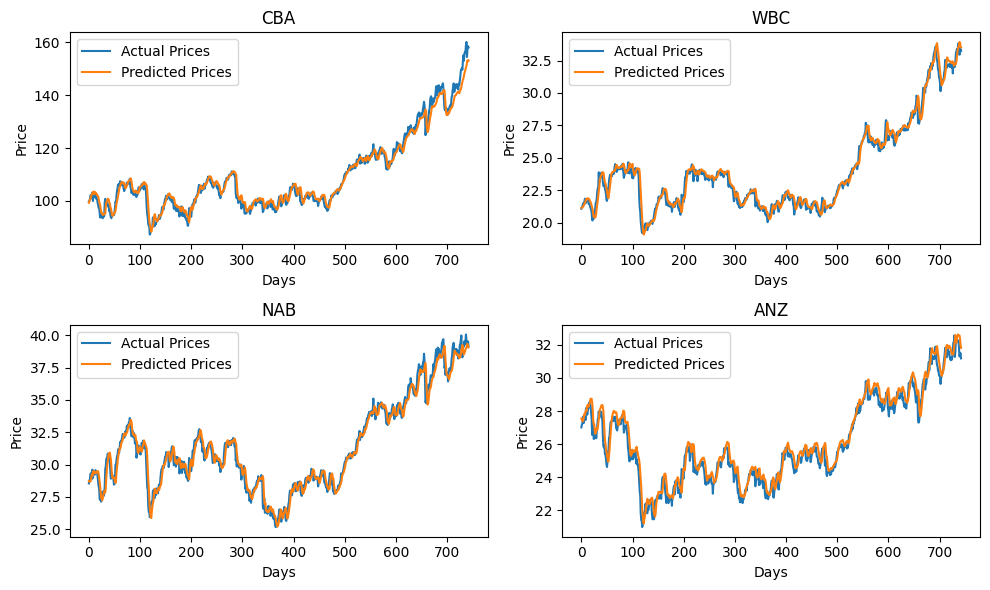

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].plot(actual_comm, label='Actual Prices')
axs[0, 0].plot(predicted_comm, label='Predicted Prices')
axs[0, 0].set_xlabel('Days')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()
axs[0, 0].set_title("CBA")

axs[0, 1].plot(actual_westpac, label='Actual Prices')
axs[0, 1].plot(predicted_westpac, label='Predicted Prices')
axs[0, 1].set_xlabel('Days')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()
axs[0, 1].set_title("WBC")

axs[1, 0].plot(actual_nab, label='Actual Prices')
axs[1, 0].plot(predicted_nab, label='Predicted Prices')
axs[1, 0].set_xlabel('Days')
axs[1, 0].set_ylabel('Price')
axs[1, 0].legend()
axs[1, 0].set_title("NAB")

axs[1, 1].plot(actual_anz, label='Actual Prices')
axs[1, 1].plot(predicted_anz, label='Predicted Prices')
axs[1, 1].set_xlabel('Days')
axs[1, 1].set_ylabel('Price')
axs[1, 1].legend()
axs[1, 1].set_title("ANZ")

plt.tight_layout()
plt.show()

In [13]:
def predict_for_next_120_days(model, stock_prices_scaled, scaler):
    predictions = [np.float32(scaler.inverse_transform(stock_prices_scaled[-1].reshape(-1, 1))[0][0])]
    
    data_for_prediction = stock_prices_scaled.copy()
    
    for iter in range(120):
        # Use data for latest 60 days to predict next day's stock price
        last_60_days = data_for_prediction[-60:]
        last_60_days = last_60_days.reshape(1, -1, 1)

        # Predict the next day's stock price
        predicted_next_day_price_scaled = model.predict(last_60_days, verbose = 0)
        predicted_next_day_price = scaler.inverse_transform(predicted_next_day_price_scaled)
        
        data_for_prediction = np.append(data_for_prediction, predicted_next_day_price_scaled).reshape(-1, 1)
        predictions.append(predicted_next_day_price[0][0])
        
    return predictions

In [14]:
predictions_120_days_comm = predict_for_next_120_days(model_comm, stock_prices_scaled_comm, scaler_comm)
predictions_120_days_westpac = predict_for_next_120_days(model_westpac, stock_prices_scaled_westpac, scaler_westpac)
predictions_120_days_nab = predict_for_next_120_days(model_nab, stock_prices_scaled_nab, scaler_nab)
predictions_120_days_anz = predict_for_next_120_days(model_anz, stock_prices_scaled_anz, scaler_anz)

In [15]:
ROI = {"Corporates": ["CBA", "WBC", "NAB", "ANZ"], "30 days": [], "60 days": [], "90 days": [], "120 days": []}

predictions = [predictions_120_days_comm, predictions_120_days_westpac, predictions_120_days_nab, predictions_120_days_anz]

for prediction in predictions:
    buyin = prediction[0]
    day30 = prediction[30]
    day60 = prediction[60]
    day90 = prediction[90]
    day120 = prediction[120]
    ROI["30 days"].append((day30 - buyin)/buyin * 100)
    ROI["60 days"].append((day60 - buyin)/buyin * 100)
    ROI["90 days"].append((day90 - buyin)/buyin * 100)
    ROI["120 days"].append((day120 - buyin)/buyin * 100)

roi = pd.DataFrame(ROI)

roi

,Corporates,30 days,60 days,90 days,120 days
0,CBA,-16.430704,-19.840871,-20.989016,-21.408291
1,WBC,14.315818,23.585717,28.126824,30.203283
2,NAB,-5.958383,-7.997621,-8.932696,-9.369498
3,ANZ,14.440306,23.045273,27.944419,30.346823


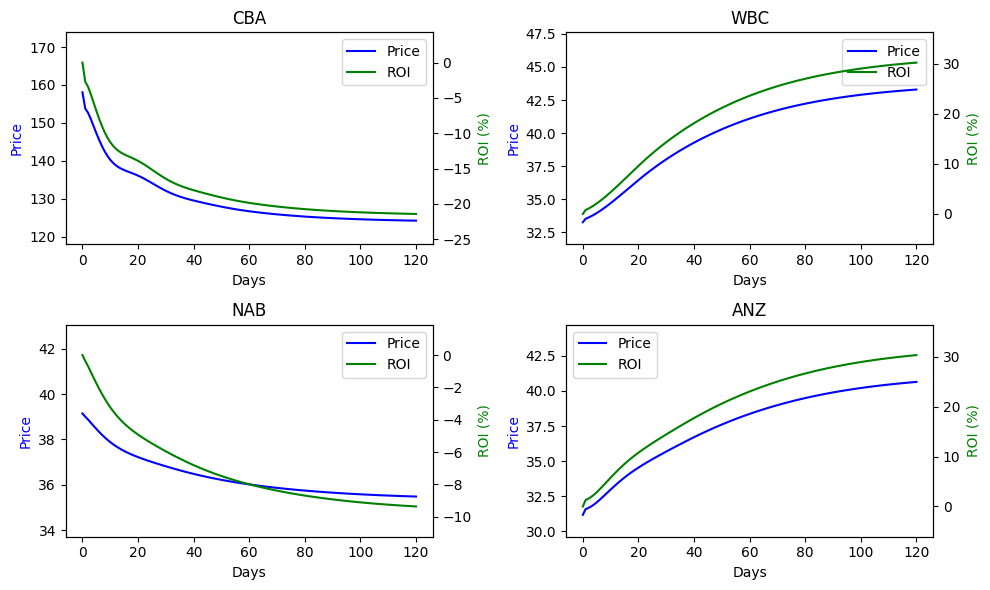

In [16]:
# Create a function to calculate the daily ROI for each corporate
def calculate_roi_for_predictions(predictions, initial_price):
    return [(day - initial_price) / initial_price * 100 for day in predictions]

# Define initial buy-in price (first day of the prediction)
buyin_comm = predictions_120_days_comm[0]
buyin_wbc = predictions_120_days_westpac[0]
buyin_nab = predictions_120_days_nab[0]
buyin_anz = predictions_120_days_anz[0]

# Calculate daily ROI for each corporate
roi_comm = calculate_roi_for_predictions(predictions_120_days_comm, buyin_comm)
roi_wbc = calculate_roi_for_predictions(predictions_120_days_westpac, buyin_wbc)
roi_nab = calculate_roi_for_predictions(predictions_120_days_nab, buyin_nab)
roi_anz = calculate_roi_for_predictions(predictions_120_days_anz, buyin_anz)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Function to plot both price and ROI on the same axis and add combined legends
def plot_price_and_roi(ax, price_predictions, roi_predictions, price_label, roi_label, location='upper right'):
    # Plot the price predictions
    price_line, = ax.plot(price_predictions, label=price_label, color='blue')
    ax.set_ylabel('Price', color='blue')
    
    # Create a second y-axis for ROI and plot the ROI predictions
    ax2 = ax.twinx()
    roi_line, = ax2.plot(roi_predictions, label=roi_label, color='green')
    ax2.set_ylabel('ROI (%)', color='green')
    
    # Adjust y-ticks for better visibility
    ax.set_ylim(min(price_predictions) * 0.95, max(price_predictions) * 1.1)
    
    # Dynamically expand the y-axis range for ROI
    roi_min = min(roi_predictions)
    roi_max = max(roi_predictions)
    margin = 0.2 * (roi_max - roi_min)  # Add 20% margin for better visibility
    ax2.set_ylim(roi_min - margin, roi_max + margin)
    
    # Combine the handles and labels for both axes into one legend
    lines = [price_line, roi_line]
    labels = [price_label, roi_label]
    
    # Display the combined legend on the plot
    ax.legend(lines, labels, loc=location, frameon=True)

# Plot for CBA
ax1 = axs[0, 0]
ax1.set_xlabel('Days')
ax1.set_title("CBA")
plot_price_and_roi(ax1, predictions_120_days_comm, roi_comm, 'Price', 'ROI')

# Plot for WBC
ax2 = axs[0, 1]
ax2.set_xlabel('Days')
ax2.set_title("WBC")
plot_price_and_roi(ax2, predictions_120_days_westpac, roi_wbc, 'Price', 'ROI')

# Plot for NAB
ax3 = axs[1, 0]
ax3.set_xlabel('Days')
ax3.set_title("NAB")
plot_price_and_roi(ax3, predictions_120_days_nab, roi_nab, 'Price', 'ROI')

# Plot for ANZ
ax4 = axs[1, 1]
ax4.set_xlabel('Days')
ax4.set_title("ANZ")
plot_price_and_roi(ax4, predictions_120_days_anz, roi_anz, 'Price', 'ROI', 'upper left')

plt.tight_layout()
plt.show()